In [12]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import uniform, randint

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# **1. Load preprocessed datasets**

In [13]:
# train dataset
X_train = pd.read_csv('X_train_balanced.csv')
y_train = pd.read_csv('y_train_balanced.csv').squeeze()

# test dataset
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv').squeeze()

In [14]:
X_train.head(5)

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineBackup,DeviceProtection,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0.0,0.0,0.102371,1.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,-0.521976,-0.263290
1,0,1.0,1.0,-0.711743,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.337478,-0.504815
2,0,1.0,1.0,-0.793155,1.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0,-0.809013,-0.751214
3,0,1.0,0.0,-0.263980,1.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,0.284384,-0.173700
4,0,1.0,1.0,-1.281624,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-0.676279,-0.990851


# **2. Train the models using 5-Fold cross-validation**

In [ ]:
# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define all models with reasonable default parameters
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(
        class_weight='balanced',
        kernel='rbf',
        probability=True,
        random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1),
    "LightGBM": LGBMClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
}

# Evaluate each model with cross-validation
results = {}
for name, model in models.items():
    # Use F1 score as primary metric (still good for balanced data)
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )
    results[name] = scores
    print(f"{name}: Mean F1 = {scores.mean():.4f} ± {scores.std():.4f}")

# Create a results dataframe for better visualization
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Mean F1': [np.mean(scores) for scores in results.values()],
    'Std Dev': [np.std(scores) for scores in results.values()]
})

# Sort by performance
results_df = results_df.sort_values('Mean F1', ascending=False)

# Print results table
print("\nModel Comparison (5-Fold Cross-Validation):")
print(results_df.to_string(index=False))

Logistic Regression: Mean F1 = 0.7779 ± 0.0081
Decision Tree: Mean F1 = 0.7829 ± 0.0106
Random Forest: Mean F1 = 0.8472 ± 0.0126
Gradient Boosting: Mean F1 = 0.8341 ± 0.0117
SVM: Mean F1 = 0.7806 ± 0.0022
KNN: Mean F1 = 0.8141 ± 0.0072
Naive Bayes: Mean F1 = 0.7639 ± 0.0085
XGBoost: Mean F1 = 0.8453 ± 0.0106
LightGBM: Mean F1 = 0.8532 ± 0.0103

Model Comparison (5-Fold Cross-Validation):
              Model  Mean F1  Std Dev
           LightGBM 0.853180 0.010274
      Random Forest 0.847186 0.012595
            XGBoost 0.845340 0.010613
  Gradient Boosting 0.834098 0.011656
                KNN 0.814083 0.007182
      Decision Tree 0.782882 0.010607
                SVM 0.780575 0.002204
Logistic Regression 0.777873 0.008128
        Naive Bayes 0.763919 0.008477


In [16]:
# Identify best model from results_df
best_model_name = results_df.iloc[0]['Model']

# Hyperparameter tuning for top performer
if best_model_name == "LightGBM":
    param_dist = {
        'num_leaves': randint(20, 50),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5)
    }

    tuner = RandomizedSearchCV(
        LGBMClassifier(class_weight='balanced', random_state=42),
        param_distributions=param_dist,
        n_iter=15,
        cv=cv,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    tuner.fit(X_train, y_train)
    models[best_model_name] = tuner.best_estimator_  # Replace with tuned model

[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1349
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [17]:
# Train final models on the full balanced training data
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"Trained {name} model")

Trained Logistic Regression model
Trained Decision Tree model
Trained Random Forest model
Trained Gradient Boosting model
Trained SVM model
Trained KNN model
Trained Naive Bayes model
Trained XGBoost model
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1349
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Trained LightGBM model


# **3. Predict all the trained models**

In [18]:
# Generate predictions for all models on test data
predictions = {}
probabilities = {}

for name, model in trained_models.items():
    # Get class predictions
    predictions[name] = model.predict(X_test)

    # Get probability predictions (for models that support it)
    if hasattr(model, 'predict_proba'):
        probabilities[name] = model.predict_proba(X_test)[:, 1]
    else:
        # For models without probability estimates
        probabilities[name] = np.zeros(len(X_test))

print("Predictions generated for all models")

Predictions generated for all models


In [19]:
# For your best model's probabilities:
best_threshold = 0.0
best_f1 = 0.0
for threshold in np.arange(0.1, 0.9, 0.05):
    preds = (probabilities[best_model_name] > threshold).astype(int)
    current_f1 = f1_score(y_test, preds)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

# Use best_threshold for final predictions

# **4. Performance evaluation of each model**

In [20]:
def evaluate_model(model, X, y_true, model_name="Model"):
  y_pred = model.predict(X)
  acc = accuracy_score(y_true, y_pred)
  report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

  # Assuming binary classification with labels '0.0' and '1.0'
  # For aggregated metrics, we can use 'weighted avg'
  precision = report['weighted avg']['precision']
  recall = report['weighted avg']['recall']
  f1 = report['weighted avg']['f1-score']

  return {
      'Model': model_name,
      'Accuracy': acc,
      'Precision': precision,
      'Recall': recall,
      'F1-Score': f1
  }

results = []
results.append(evaluate_model(trained_models["Logistic Regression"], X_test, y_test, "Logistic Regression"))
results.append(evaluate_model(trained_models["Decision Tree"], X_test, y_test, "Decision Tree"))
results.append(evaluate_model(trained_models["Random Forest"], X_test, y_test, "Random Forest"))
results.append(evaluate_model(trained_models["Gradient Boosting"], X_test, y_test, "Gradient Boosting"))
results.append(evaluate_model(trained_models["SVM"], X_test, y_test, "SVM"))
results.append(evaluate_model(trained_models["KNN"], X_test, y_test, "KNN"))
results.append(evaluate_model(trained_models["Naive Bayes"], X_test, y_test, "Naive Bayes"))
results.append(evaluate_model(trained_models["XGBoost"], X_test, y_test, "XGBoost"))
results.append(evaluate_model(trained_models["LightGBM"], X_test, y_test, "LightGBM"))

results_df = pd.DataFrame(results)
print("Model Performance Evaluation:")
display(results_df)

Model Performance Evaluation:


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.728886,0.796922,0.728886,0.743866
1,Decision Tree,0.713982,0.733765,0.713982,0.721804
2,Random Forest,0.757275,0.768419,0.757275,0.761875
3,Gradient Boosting,0.766501,0.801040,0.766501,0.776393
4,SVM,0.739532,0.795095,0.739532,0.753047
5,KNN,0.706175,0.756523,0.706175,0.720593
6,Naive Bayes,0.704045,0.792322,0.704045,0.721212
7,XGBoost,0.772889,0.783971,0.772889,0.777344
8,LightGBM,0.770759,0.780300,0.770759,0.774717


# **5. Compare each model**

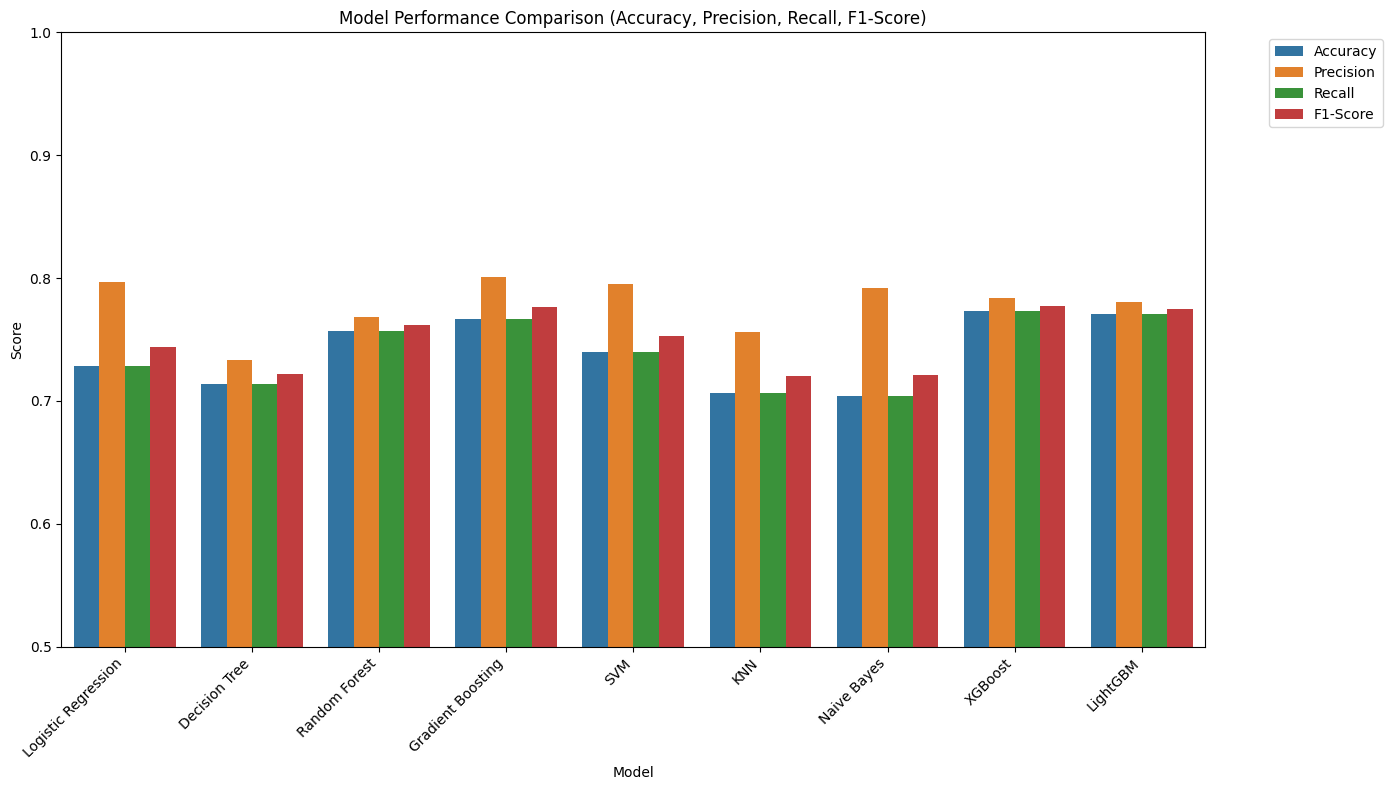

In [21]:
results_df_melted = results_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_df_melted)
plt.title('Model Performance Comparison (Accuracy, Precision, Recall, F1-Score)')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1.0) # Set a reasonable y-axis limit for performance metrics
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- The best performing model is **XGBoost**, with an F1-Score of **0.777**. It also has the highest Accuracy, Precision, and Recall among all models.
- The worst performing model is **KNN**, with an F1-Score of **0.721**. It has the lowest F1-Score, Accuracy, and Recall among all models.

# **6. Generate a confusion matrix for each model**

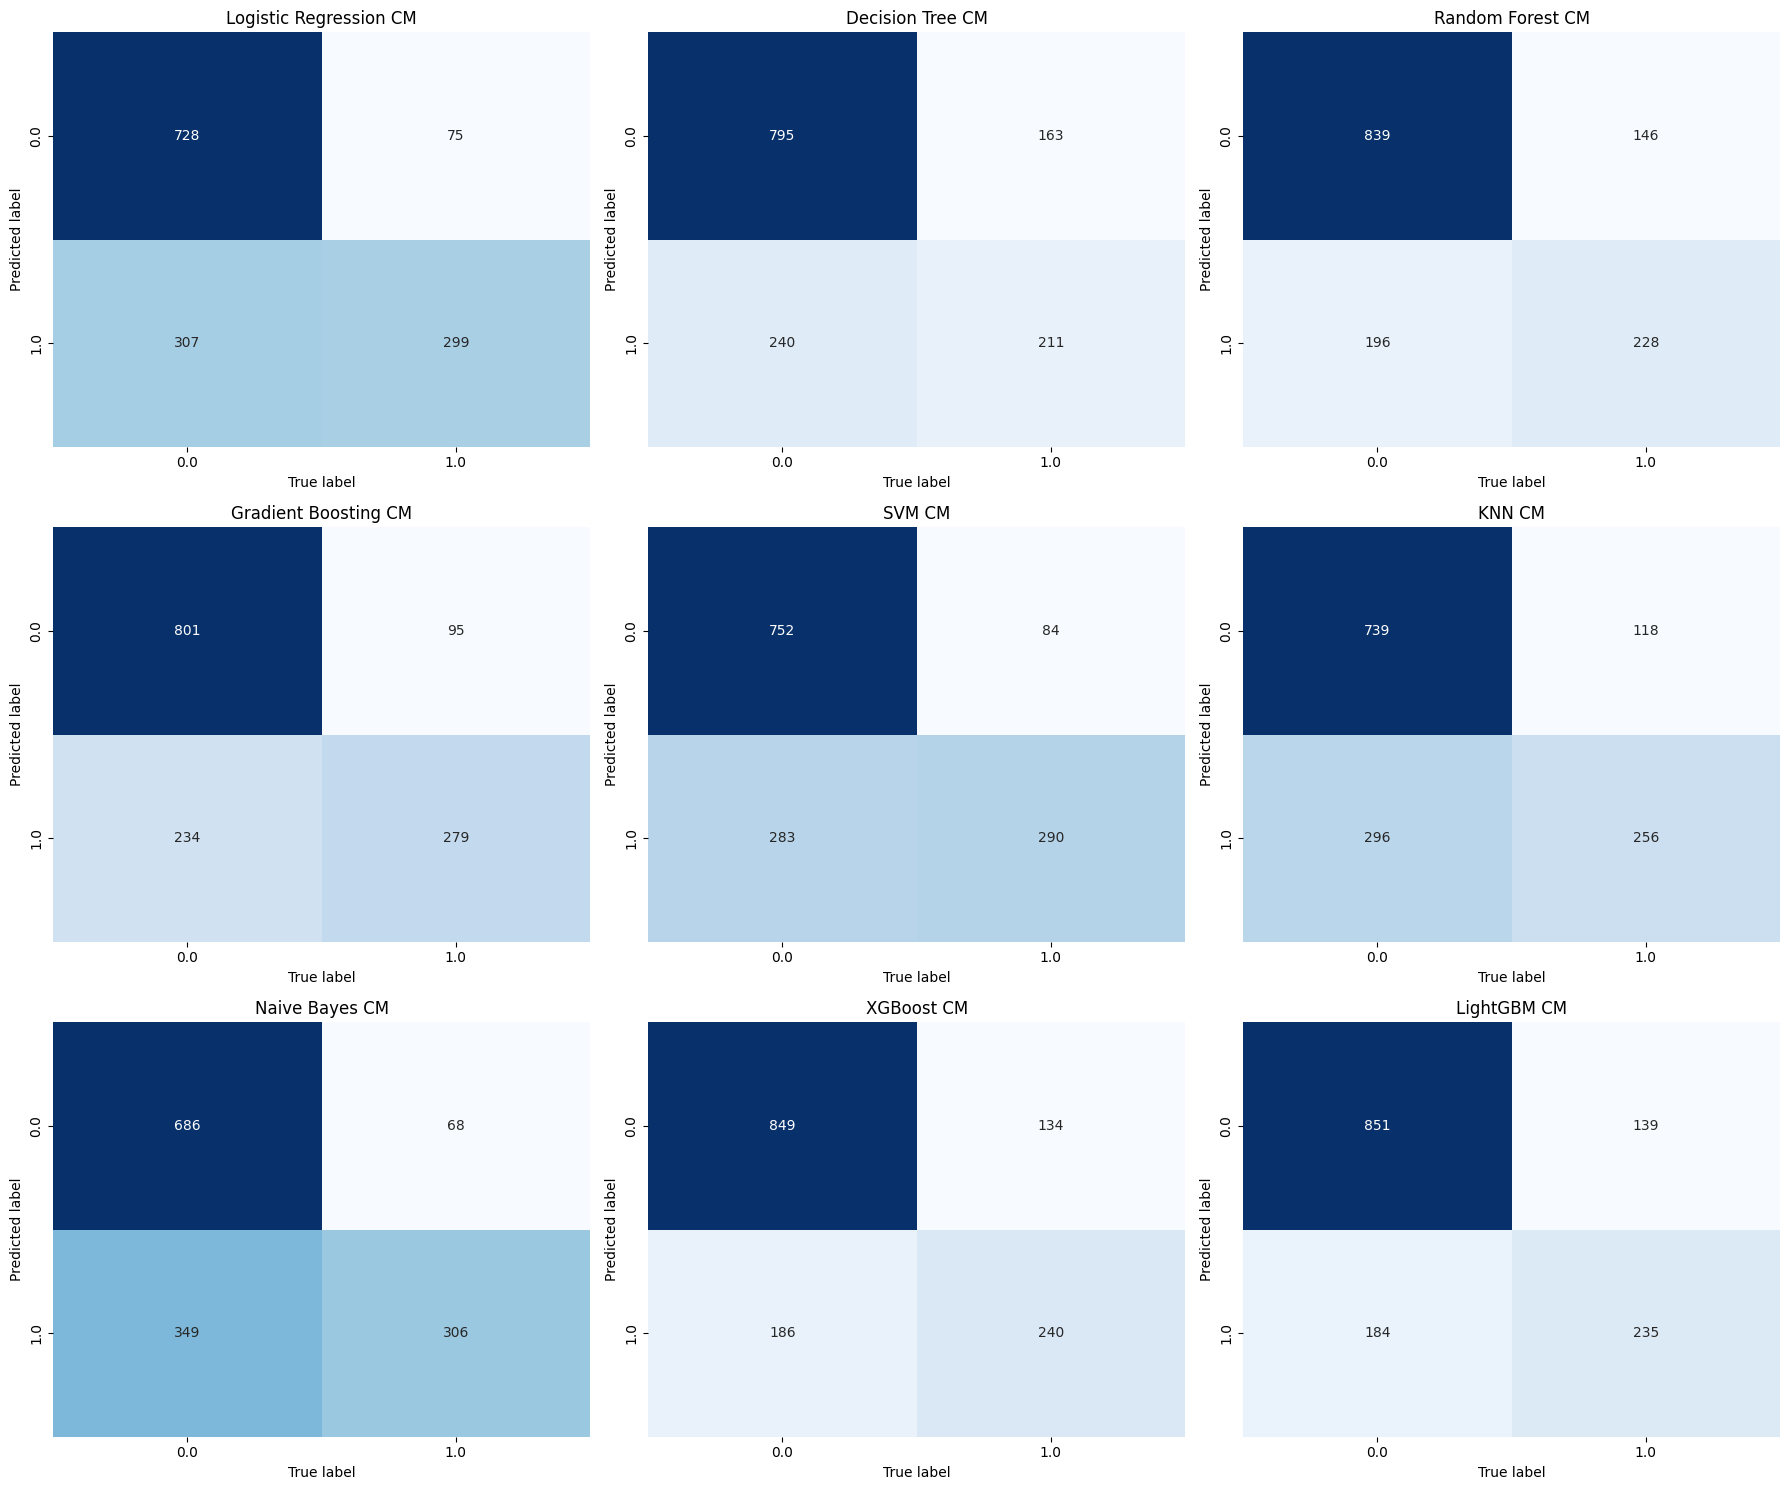

In [22]:
models = {
    "Logistic Regression": trained_models["Logistic Regression"],
    "Decision Tree": trained_models["Decision Tree"],
    "Random Forest": trained_models["Random Forest"],
    "Gradient Boosting": trained_models["Gradient Boosting"],
    "SVM": trained_models["SVM"],
    "KNN": trained_models["KNN"],
    "Naive Bayes": trained_models["Naive Bayes"],
    "XGBoost": trained_models["XGBoost"],
    "LightGBM": trained_models["LightGBM"]
}

num_models = len(models)
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols  # Calculate required number of rows

plt.figure(figsize=(num_cols * 6, num_rows * 5)) # Adjust figure size dynamically

for i, (name, model) in enumerate(models.items()):
    plt.subplot(num_rows, num_cols, i + 1)
    y_pred = model.predict(X_test)

    # Get unique labels once
    labels = np.unique(y_test)

    # Create confusion matrix with swapped axes logic
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm = cm.T # TRANSPOSE to swap axes: rows=predicted, columns=true

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels,  # True labels on x-axis
                yticklabels=labels)  # Predicted labels on y-axis

    plt.title(f'{name} CM')
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

plt.tight_layout()
plt.show()

# **7. Save the best model**

**XGBoost** is the best overall model. It has the highest scores across all metrics, especially the F1-Score (which balances Precision and Recall). This makes it the most reliable choice.

In [23]:
# XGBoost is the best overall
with open("churn_model.pkl", "wb") as f:
    pickle.dump(trained_models["XGBoost"], f)
print("Saved churn_model.pkl")

Saved churn_model.pkl
